In [61]:
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline  

ini_format = """
[General]
network = Scheduler
**.queue.serviceTime = {}s  
**.source.interArrivalTime = exponential({}s)  
**.source.numJobs = {}
**.registrar.acceptenceRate = 0.9
repeat = 1000
"""

def ini_gen(service_time=1, students=700, inter_arrival_time=0.5):
    contents = ini_format.format(service_time, inter_arrival_time, students)
    with open("custom.ini", "w") as f:
        f.write(contents)
        
def run_omnetpp():
    subprocess.call("rm results/totaled.csv", shell=True)
    subprocess.call("opp_runall -j24 -b41 ./FinalProjectTry2 -m -u Cmdenv -n .:../queueinglib -l ../queueinglib/queueinglib custom.ini -c General", shell=True)
    subprocess.call("cd results && scavetool x *.sca -o totaled.csv", shell=True)
    a = pd.read_csv("results/totaled.csv")
    return a.pivot_table(columns="name", values="value", index="run")

    
def process_results(dataset):
    def process_column(param, nice_name): 
        values = dataset[param].dropna() 
        return {f"{nice_name} Mean": values.mean(), f"{nice_name} SE": values.sem(),
                f"{nice_name} Std. Dev": values.std(), f"{nice_name} %Err": 100 * values.sem() / values.mean()}
        
    results = process_column("lifeTime:max", "Max Registration Time")
    results.update(process_column("lifeTime:mean", "Mean Registration Time"))
    results.update(process_column("queueLength:max","Max Queue Length"))
    return results

def run_simulation(service_time=1, students=700, inter_arrival_time=0.5):
    ini_gen(service_time, students, inter_arrival_time) 
    a = run_omnetpp()
    results = process_results(a)
    results["Service Time"] = service_time
    results["Students"] = students
    results["Inter-arrival Time"] = inter_arrival_time
    return results 

def fix_order(columns):
    columns = list(columns)
    for c in ["Service Time", "Students", "Inter-arrival Time"]:
        columns.remove(c)
        columns.insert(0, c)
    return columns

def pretty_format(data):
    return pd.DataFrame(data, columns=fix_order(data[0].keys()))

def save_plot(name):
    plt.savefig(f"images/{name}.png", dpi=300)

In [45]:
run_simulation(1, 100)

{'Max Registration Time Mean': 83.55854493959164,
 'Max Registration Time SE': 0.29442697185679984,
 'Max Registration Time Std. Dev': 9.310598356537822,
 'Max Registration Time %Err': 0.3523600992210369,
 'Mean Registration Time Mean': 31.66950963124321,
 'Mean Registration Time SE': 0.106778243995269,
 'Mean Registration Time Std. Dev': 3.3766245557824757,
 'Mean Registration Time %Err': 0.33716418485345945,
 'Max Queue Length Mean': 55.267,
 'Max Queue Length SE': 0.1497201627274267,
 'Max Queue Length Std. Dev': 4.734567258697159,
 'Max Queue Length %Err': 0.2709033649871111,
 'Service Time': 1,
 'Students': 100,
 'Inter-arrival Time': 0.5}

In [69]:
student_trials = pretty_format([run_simulation(students=s) for s in tqdm_notebook(np.linspace(700, 1500, 10, dtype=int))])
service_time_trials = pretty_format([run_simulation(service_time=s) for s in tqdm_notebook(np.linspace(0.5, 10, 10))])
iit = pretty_format([run_simulation(inter_arrival_time=s) for s in tqdm_notebook(np.linspace(0, 10, 20))]) 


KeyboardInterrupt: 

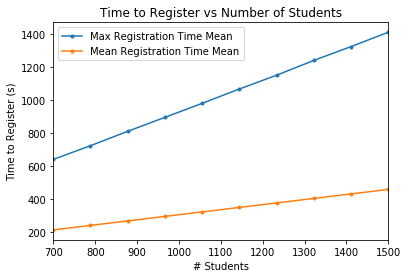

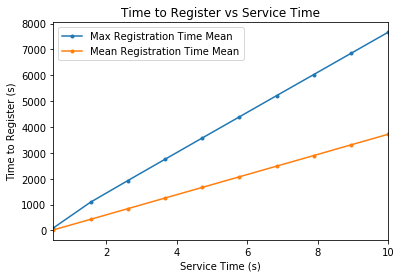

In [77]:
def plot_values(frame, x_col, y_cols, style=".-"):
    frame[[x_col] + y_cols].plot(x=x_col, style=style)

plot_values(student_trials, "Students", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("# Students")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Number of Students")
save_plot("Time to Register vs Number of Students")

plot_values(service_time_trials, "Service Time", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("Service Time (s)")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Service Time")
save_plot("Time to Register vs Service Time")



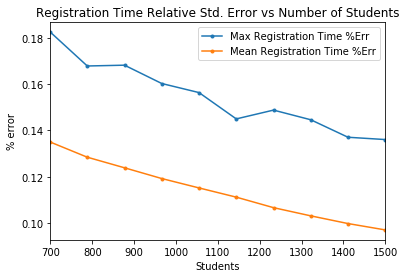

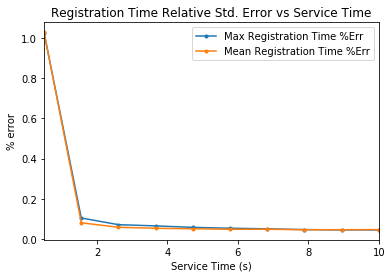

In [68]:
plot_values(student_trials, "Students", ["Max Registration Time %Err", "Mean Registration Time %Err"])
plt.ylabel("% error")
plt.title("Registration Time Relative Std. Error vs Number of Students")
save_plot("Registration Time Relative Std. Error vs Number of Students")

plot_values(service_time_trials, "Service Time", ["Max Registration Time %Err", "Mean Registration Time %Err"])
plt.xlabel("Service Time (s)")
plt.ylabel("% error")
plt.title("Registration Time Relative Std. Error vs Service Time")
save_plot("Registration Time Relative Std. Error vs Service Time")

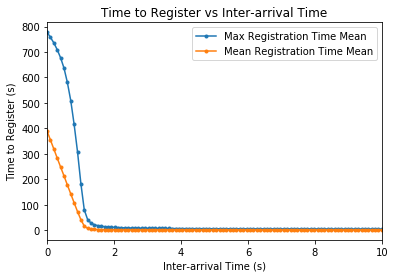

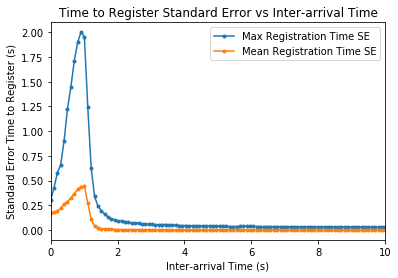

In [78]:
plot_values(iit, "Inter-arrival Time", ["Max Registration Time Mean", "Mean Registration Time Mean"])
plt.xlabel("Inter-arrival Time (s)")
plt.ylabel("Time to Register (s)")
plt.title("Time to Register vs Inter-arrival Time")
save_plot("Time to Register vs Inter-arrival Time")

plot_values(iit, "Inter-arrival Time", ["Max Registration Time SE", "Mean Registration Time SE"])
plt.xlabel("Inter-arrival Time (s)")
plt.ylabel("Standard Error Time to Register (s)")
plt.title("Time to Register Standard Error vs Inter-arrival Time")
save_plot("Time to Register Standard Error vs Inter-arrival Time")

In [34]:
student_trials.round(2)

,Inter-arrival Time,Students,Service Time,Max Registration Time mean,Max Registration Time sem,Max Registration Time stdev,Max Registration Time %err,Mean Registration Time mean,Mean Registration Time sem,Mean Registration Time stdev,Mean Registration Time %err,Max Queue Length mean,Max Queue Length sem,Max Queue Length stdev,Max Queue Length %err
0,0.5,700,1,323.47,7.15,319.87,2.21,108.21,2.40,107.24,2.22,193.94,4.29,192.02,2.21
1,0.5,788,1,364.43,8.07,360.79,2.21,121.72,2.70,120.76,2.22,218.24,4.84,216.33,2.22
2,0.5,877,1,408.03,9.05,404.53,2.22,135.38,3.01,134.43,2.22,242.79,5.39,240.89,2.22
3,0.5,966,1,450.27,9.99,446.77,2.22,149.00,3.31,148.06,2.22,267.32,5.94,265.43,2.22
4,0.5,1055,1,492.66,10.94,489.23,2.22,162.62,3.62,161.69,2.22,291.75,6.48,289.87,2.22
5,0.5,1144,1,536.11,11.91,532.61,2.22,176.20,3.92,175.28,2.22,316.20,7.03,314.31,2.22
6,0.5,1233,1,577.75,12.84,574.41,2.22,189.84,4.22,188.92,2.23,340.75,7.58,338.87,2.22
7,0.5,1322,1,622.61,13.85,619.31,2.22,203.47,4.53,202.54,2.23,365.22,8.12,363.35,2.22
8,0.5,1411,1,664.37,14.78,661.02,2.22,217.10,4.83,216.18,2.23,389.79,8.67,387.92,2.23
9,0.5,1500,1,707.84,15.75,704.57,2.23,230.67,5.14,229.76,2.23,414.21,9.22,412.35,2.23


In [76]:
iit = pretty_format([run_simulation(inter_arrival_time=s) for s in tqdm_notebook(np.linspace(0, 10, 100))]) 
